# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1:Omri 5771
# student 2:Itay 5637

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


In [3]:
def load_dataset(filepath):
    return pd.read_csv(filepath)

In [4]:
df_train = load_dataset("titanic_train.csv")
df_test = load_dataset("titanic_test.csv")

print(df_train.shape)
print(df_test.shape)

print(df_train.head())
print(df_test.head())

df_train.describe()

(712, 8)
(179, 8)
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.294944,0.640449,29.531213,0.528090,0.384831,32.379429,0.372191,0.394663
std,0.841990,0.480206,13.188028,1.055052,0.803085,49.836074,0.649970,0.489122
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.500000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


[Text(0, 0, 'Dead'), Text(1, 0, 'Survived')]

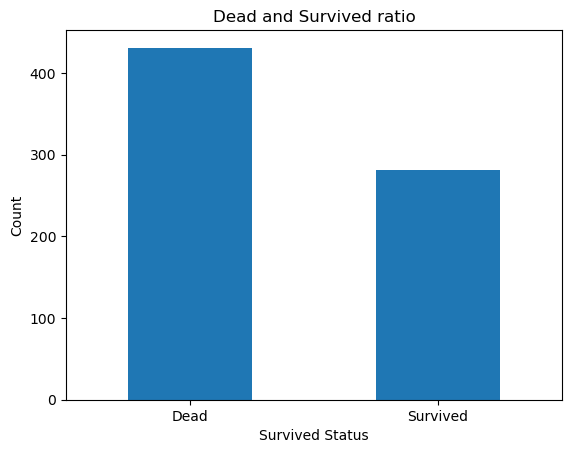

In [5]:
ax = df_train["Survived"].value_counts().plot(kind='bar', title="Dead and Survived ratio", ylabel='Count', xlabel='Survived Status')
ax.set_xticklabels(['Dead', 'Survived'], rotation=0)


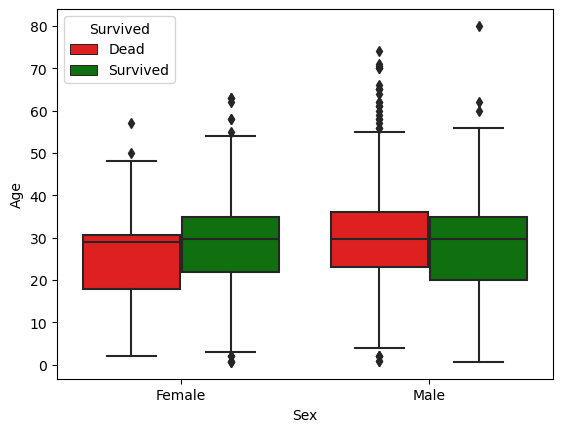

In [6]:
box_plot = sns.boxplot(x='Sex', y='Age', hue='Survived', data=df_train, palette={0: 'r', 1: 'g'})
box_plot.set_xticklabels(['Female', 'Male'])
new_labels = ['Dead', 'Survived']
for t, l in zip(box_plot.legend_.texts, new_labels): 
    t.set_text(l)

In [7]:
cross = pd.crosstab( df_train['Pclass'], df_train['Survived'], normalize="index", margins=True)
cross.rename(columns={0: 'Dead', 1:'Survived'})

Survived,Dead,Survived
Pclass,,
1,0.365169,0.634831
2,0.541096,0.458904
3,0.739691,0.260309
All,0.605337,0.394663


In [8]:
comparison_table = df_train.groupby('Survived')['Fare'].mean().reset_index()
comparison_table.columns = ['Survived', 'Average Fare']
display(comparison_table)


,Survived,Average Fare
0,0,21.749650
1,1,48.683468


In [9]:
fare_bins = [-1, 10, 20, 50, 100, 600]  # הגדרת הקטגוריות
fare_labels = ['0-10', '11-20', '21-50', '51-100', '100+']  # תוויות לקטגוריות

df_train['Fare_Category'] = pd.cut(df_train['Fare'], bins=fare_bins, labels=fare_labels)

fare_survival_table = df_train.groupby(['Fare_Category', 'Survived'], observed=True).size().unstack().fillna(0)
fare_survival_table['Survival_Rate'] = fare_survival_table[1] / (fare_survival_table[0] + fare_survival_table[1])


fare_survival_table


Survived,0,1,Survival_Rate
Fare_Category,,,
0-10,199,56,0.219608
11-20,90,63,0.411765
21-50,99,73,0.424419
51-100,33,57,0.633333
100+,10,32,0.761905


## Part 3 - Experiments
You could add as many code cells as neede


In [10]:
def merge_family_columns(data):
    data["Family_Size"] = data["SibSp"] + data["Parch"]
    data.drop(columns=["SibSp", "Parch"], inplace=True)
    return data


In [11]:
def normalize_training_data(data):
    age_normalizer = preprocessing.MinMaxScaler()
    fare_normalizer = preprocessing.MinMaxScaler()
    data["Age"] = age_normalizer.fit_transform(data[['Age']])
    data["Fare"] = fare_normalizer.fit_transform(data[['Fare']])
    return age_normalizer, fare_normalizer, data

In [12]:
def normalize_test_data(age_normalizer, fare_normalizer, data):
    data["Age"] = age_normalizer.transform(data[['Age']])
    data["Fare"] = fare_normalizer.transform(data[['Fare']])
    return data


In [13]:
def preprocess_data(train_data, test_data):
    train_clean = train_data.copy(deep=True)
    test_clean = test_data.copy(deep=True)
    
    train_clean = merge_family_columns(train_clean)
    test_clean = merge_family_columns(test_clean)
    
    age_normalizer, fare_normalizer, train_clean = normalize_training_data(train_clean)
    test_clean = normalize_test_data(age_normalizer, fare_normalizer, test_clean)

    return train_clean, test_clean

In [14]:

train_clean_data, test_clean_data = preprocess_data(df_train, df_test)
x_train = train_clean_data.drop(['Survived'], axis=1)
y_train = train_clean_data['Survived']

##  Training 


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [15]:

label_encoder = LabelEncoder()

if 'Fare_Category' in x_train.columns:
    x_train['Fare_Category'] = label_encoder.fit_transform(x_train['Fare_Category'])


if 'Embarked' in x_train.columns:
    x_train['Embarked'] = label_encoder.fit_transform(x_train['Embarked'])

param_grid_knn = {
    'n_neighbors': np.arange(1, 35),
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}


knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', verbose=0)

grid_search_knn.fit(x_train, y_train)

print("Best parameters found for KNN: ", grid_search_knn.best_params_)
print("Best F1 score: ", grid_search_knn.best_score_)

Best parameters found for KNN:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best F1 score:  0.7275841030322523


In [16]:
param_grid_dtc = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'criterion': ['gini', 'entropy']
}
dtc = DecisionTreeClassifier() 
grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5, scoring='f1', verbose=0)
grid_search_dtc.fit(x_train, y_train);

In [17]:
def print_top_results(grid_search, n):
    result_df = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
    display(result_df.sort_values('Accuracy',ascending = False).head(n))
print_top_results(grid_search_knn, 10)
print_top_results(grid_search_dtc, 10)

,metric,n_neighbors,weights,Accuracy
152,manhattan,9,uniform,0.727584
157,manhattan,11,distance,0.726212
89,euclidean,11,distance,0.721001
21,minkowski,11,distance,0.721001
131,euclidean,32,distance,0.719235
63,minkowski,32,distance,0.719235
203,manhattan,34,distance,0.719198
199,manhattan,32,distance,0.719198
195,manhattan,30,distance,0.718271
135,euclidean,34,distance,0.718226


,criterion,max_depth,min_samples_leaf,min_samples_split,Accuracy
113,entropy,10.0,8,5,0.738359
74,entropy,NaN,8,10,0.738359
72,entropy,NaN,8,2,0.738359
114,entropy,10.0,8,10,0.738359
102,entropy,10.0,1,10,0.737564
62,entropy,NaN,1,10,0.737498
75,entropy,NaN,8,15,0.737287
73,entropy,NaN,8,5,0.737287
112,entropy,10.0,8,2,0.737287
115,entropy,10.0,8,15,0.737287


## Part 5 - Apply on test and show model performance estimation

In [18]:
optimal_params = grid_search_dtc.best_params_

optimal_decision_tree = DecisionTreeClassifier(**optimal_params)

print(f"Optimal Decision Tree Model: {optimal_decision_tree}")


optimal_decision_tree.fit(x_train, y_train)

Optimal Decision Tree Model: DecisionTreeClassifier(criterion='entropy', min_samples_leaf=8)


DecisionTreeClassifier(criterion='entropy', min_samples_leaf=8)

In [19]:
df_train = load_dataset("titanic_train.csv")
df_test_clean = load_dataset("titanic_test.csv")

In [20]:
x_train = df_train.drop(['Survived'], axis=1) 
y_train = df_train['Survived']  
x_test = df_test_clean.drop(['Survived'], axis=1) 
y_test = df_test_clean['Survived']  

x_test = x_test.reindex(columns=x_train.columns, fill_value=0)


optimal_decision_tree.fit(x_train, y_train)


pred = optimal_decision_tree.predict(x_test)
acc = accuracy_score(y_test, pred)
print(f'Accuracy: {acc}')


df_compare = pd.DataFrame({'prediction': pred, 'true value': y_test})
display(df_compare.head(20))

Accuracy: 0.8547486033519553


,prediction,true value
0,0,0
1,0,0
2,0,0
3,1,0
4,0,1
5,0,1
6,0,0
7,0,0
8,1,1
9,0,0
